`https://python.langchain.com/docs/tutorials/rag/#orchestration`

In [278]:
import os
from langchain.chat_models import init_chat_model
from openai import api_key
from typing_extensions import Annotated, TypedDict
from langchain_community.vectorstores import FAISS
from helper.academicCloudEmbeddings import AcademicCloudEmbeddings
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
import streamlit as st
from langchain_community.chat_models import ChatOpenAI
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from langchain_core.prompts import PromptTemplate

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = st.secrets["GWDG_API_KEY"]

# Retrieval and Generation
- taking a user question
- searching for documents
- passing retrieved documents and question to model
- returning an answer

### using a prompt for RAG by LangChain

In [279]:

template = """Du bist der hilfreiche StudIT‑Assistent der Universität Göttingen.
• Antworte bevorzugt auf Deutsch.
• Antworte so kurz wie möglich, aber so ausführlich wie nötig.
• Falls du die Antwort nicht sicher weißt, schlage konkrete Anlaufstellen (Link oder E‑Mail) vor. Gib niemals eine Antwort von der du nicht 100% sicher bist, dass sie stimmt.
Nutze den folgenden Kontext um die Frage zu beantworten:
{context}

Frage: {question}

Antwort:"""
prompt = PromptTemplate.from_template(template)
example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

Du bist der hilfreiche StudIT‑Assistent der Universität Göttingen.
• Antworte bevorzugt auf Deutsch.
• Antworte so kurz wie möglich, aber so ausführlich wie nötig.
• Falls du die Antwort nicht sicher weißt, schlage konkrete Anlaufstellen (Link oder E‑Mail) vor. Gib niemals eine Antwort von der du nicht 100% sicher bist, dass sie stimmt.
Nutze den folgenden Kontext um die Frage zu beantworten:
(context goes here)

Frage: (question goes here)

Antwort:


### add tool for returning sources

In [280]:
# Desired schema for response
class AnswerWithSources(TypedDict):
    """An answer to the question, with sources."""

    answer: str
    sources: Annotated[
        List[str],
        ...,
        "List of sources (url) used to answer the question",
    ]

## LangGraph
`https://langchain-ai.github.io/langgraph/?_gl=1*ozejfv*_ga*MjE0MzQ1NDExNS4xNzUxNDYxNDM0*_ga_47WX3HKKY2*czE3NTMzNjk1MTgkbzExJGcxJHQxNzUzMzcxODYxJGo2MCRsMCRoMA..`

### 1. Define State:
- controls what data is input to the application, transferred between steps, and output by the application
- keep track of input question, retrieved context, and generated answer

In [281]:
from langgraph.graph import MessagesState, StateGraph
class State(MessagesState):
    context: List[Document]

#### load the vector store and models first

In [282]:
VECTORSTORE_PATH = ("faiss_wiki_index")
embedder = AcademicCloudEmbeddings(
        api_key=st.secrets["GWDG_API_KEY"],
        url=st.secrets["BASE_URL_EMBEDDINGS"],
    )

vector_store = FAISS.load_local(
        VECTORSTORE_PATH,
        embedder,
        allow_dangerous_deserialization=True,
    )

llm = init_chat_model("meta-llama-3.1-8b-instruct", model_provider="openai", base_url=st.secrets["BASE_URL"],temperature=0, api_key=st.secrets["GWDG_API_KEY"])

### 2. Nodes
- retrieval
- generation

In [283]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Recherche‑Tool NUR für technische Fragen zur Uni Göttingen.
    Rufe es auf, wenn die Nutzerfrage eindeutig dazu passt.
    Gebe sonst KEIN Tool‑Call zurück."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "Du bist ein Assistent, welcher Fragen beantworten soll. "
        "Antworte **ohne** interne Erklärungen oder Meta‑Kommentare. "
        "Wenn KEIN Tool benötigt wird, antworte einfach direkt. "
        "Nutze die folgenden Abschnitte aus dem Kontext zu Beantwortung der Frage. "
        "Wenn du die Antwort nicht kennst sag das einfach."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    context = []
    for tool_message in tool_messages:
        context.extend(tool_message.artifact)
    return {"messages": [response], "context": context}

### 3. compiling into a single graph object
- connecting the retrieval and generation stepts into a single sequence

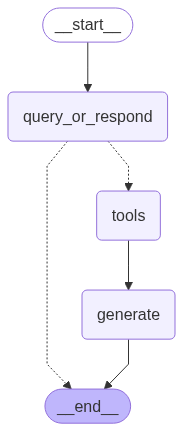

In [284]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### 4. Usage

In [285]:


input_message = "Welche Standorte hat StudIT?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Welche Standorte hat StudIT?
================================== Ai Message ==================================
Tool Calls:
  retrieve (chatcmpl-tool-93694dfd2b274d648009c41408b32c17)
 Call ID: chatcmpl-tool-93694dfd2b274d648009c41408b32c17
  Args:
    query: StudIT-Standorte
================================= Tool Message =================================
Name: retrieve

Source: {'url': 'https://wiki.student.uni-goettingen.de/support/studit_support/standorte'}
Content: support/studit_support/standorte.txt
· Zuletzt geändert: 17.07.2025 11:19 von
lange43
Seiten-Werkzeuge
Zeige Quelltext
Ältere Versionen
Links hierher
PDF exportieren
ODT exportieren
Nach oben
de
en

Source: {'url': 'https://wiki.student.uni-goettingen.de/'}
Content: Mit unserem Angebot geben wir Euch in Form von Beratung und Software das Rüstzeug, um Eure kreativen Ideen für Euer Studium in die Realität umzusetzen.
Wir stehen euch an drei Sta

In [286]:


input_message = "Wie sind bei dem zweiten Standort die Öffnungszeiten?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()


================================ Human Message =================================

Wie sind bei dem zweiten Standort die Öffnungszeiten?
================================== Ai Message ==================================
Tool Calls:
  retrieve (chatcmpl-tool-5864cc8d0b5d4bc7af6a627270062434)
 Call ID: chatcmpl-tool-5864cc8d0b5d4bc7af6a627270062434
  Args:
    query: Öffnungszeiten StudIT Klinikum
================================= Tool Message =================================
Name: retrieve

Source: {'url': 'https://wiki.student.uni-goettingen.de/support/studit_support/lrc_med'}
Content: Freitag: 10:00-13:00 Uhr
In der vorlesungsfreien Zeit - vom 15. Februar bis zum 31. März und vom 15. August bis zum 30. September:
Montag bis Donnerstag: 10:00-14.00 Uhr
Freitag: 10:00-13:00 Uhr
Dort werden folgende Serviceleistungen zur Verfügung gestellt:
Ausgabe von Studierendenaccounts
Neugenerierung von Passwörtern für den Account (und damit auch für Go@Med und die SB-Funktionen)
Reguläre Account-Bera